# Assignment1
## k-Nearest Neighbor Classifier

In [13]:
# 在运行前的一些配置代码

import random 
import numpy as np 
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 像素
plt.rcParams['image.interpolation'] = 'nearest' # 差值方式
plt.rcParams['image.cmap'] = 'gray' # 颜色

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# 加载原始的 cifar-10 
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 输出训练数据和测试数据，用以一个简单的检查
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


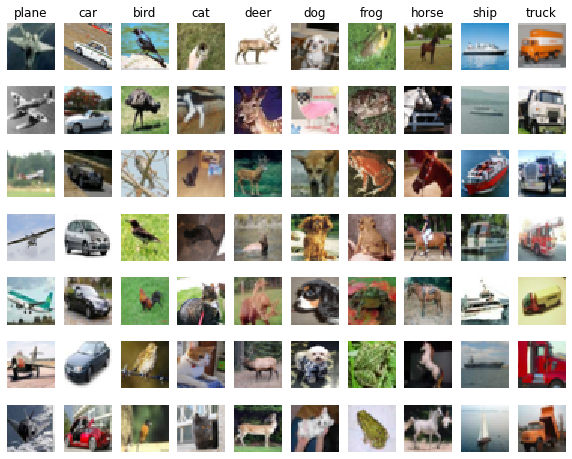

In [15]:
# 从每个类选出一些训练图片用来显示
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, ccls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # 找出标签中 y 类的位置
    idxs = np.random.choice(idxs, samples_per_class, replace = False) # 从中随机选出 7 个用于显示的样本
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1 # 计算再子图中的位置
        plt.subplot(samples_per_class, num_classes, plt_idx) # 说明要画的子图的编号
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0: plt.title(ccls)
plt.show()

In [16]:
# 对数据进行降采样
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [17]:
# 将图像数据压缩到行上
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [18]:
from cs231n.classifiers import KNearestNeighbor

# 创建一个 KNN 分类器
# Remember that training a KNN classifier is a noop 
# 对 noop 的解释是：分类器只是简单记住数据，而没有更一步的处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [19]:
# 利用双循环计算距离

dists = classifier.compute_dis_two_loops(X_test)
print(dists.shape)

(500, 5000)


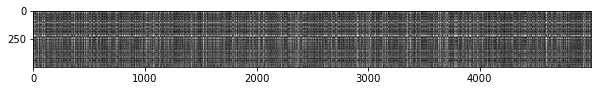

In [20]:
# 可视化距离矩阵，每一行是一个测试样例和它到训练样本的距离
plt.imshow(dists, interpolation = 'none')
plt.show()

我们注意到在上面的图片中，有的行或列会看起来高亮一些（在默认的色彩配置下，黑色表示小距离，而白色表示大距离）

有如下两个问题：
- 是什么数据上的原因导致了这些高亮的行？
- 又是什么原因导致了这些高亮的列？

答：
- 如果第 i 个测试数据和大部分的测试数据都比较相似的话，第 i 行就会看起来比较黑一些
- 如果第 j 个训练数据和大部分的测试数据都比较相似的话，第 j 列看起来就会比较黑一些

In [21]:
# 运行 predict_labels 
# 我们让 k = 1，表示最近邻
y_test_pred = classifier.predict_labels(dists, k = 1)

# 计算准确率
num_correct = np.sum(y_test_pred == y_test)
acc = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, acc))

Got 137 / 500 correct => accuracy: 0.274000


In [22]:
# k = 5
y_test_pred = classifier.predict_labels(dists, k = 5)
num_correct = np.sum(y_test_pred == y_test)
acc = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, acc))

Got 139 / 500 correct => accuracy: 0.278000


In [23]:
# 使用部分矢量化来提高距离矩阵的与运算速度
# 使用单循环计算距离矩阵
dists_one = classifier.compute_dis_one_loops(X_test)

# 为了确保部分矢量化正确，我们有必要确认它是能够在最简单的实现上运行的
# 有很多的方法可以判断两个矩阵是否相似：
# 最简单的是 F—范数 ：两个矩阵的 F-范数定义为两个矩阵所有元素的差值平方和开根号
# 换言之，将两个矩阵变为向量，计算这两个向量之间的欧式距离即是
difference = np.linalg.norm(dists - dists_one, ord = 'fro')
print('Difference was %f' % (difference,))
if difference < 0.001:
    print('Good!The distance matrices are the same')
else:
    print('Uh-oh!The distance matrices are different')


Difference was 0.000000
Good!The distance matrices are the same


In [24]:
# 使用矩阵之间无循环计算 L2 距离
dists_two = classifier.compute_dis_no_loops

# 然后使用 F-范数检查一下相似性
difference = np.linalg.norm(dists - dists_one, ord = 'fro')
print('Difference was %f' % (difference,))
if difference < 0.001:
    print('Good!The distance matrices are the same')
else:
    print('Uh-oh!The distance matrices are different')

Difference was 0.000000
Good!The distance matrices are the same


In [25]:
# 我们比较一下三个计算 L2 的实现方式，就很清楚为什么会尽可能希望将 L2 的计算用矩阵操作实现
import time 

def time_function(f, *args):
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_dis_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_dis_one_loops, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_dis_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 31.951535 seconds
One loop version took 43.825104 seconds
No loop version took 0.204045 seconds


## 交叉验证

下面将引入交叉验证来找到最好的 k 值


In [26]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# 将训练集分为 5 部分
y_train_ = y_train.reshape(-1, 1)
X_train_folds, y_train_folds = np.array_split(X_train, 5), np.array_split(y_train_, 5)

# k_to_accuracies 是一个字典数据结构，用于储存不同 k 值的交叉验证数据
# k_to_accuracies[k] 应该是一个长度为 num_folds 的列表，存储不同验证集下 k 值的准确率
k_to_accuracies = {}

# 进行交叉验证
for k_ in k_choices:
    k_to_accuracies.setdefault(k_, [])
for i in range(num_folds):
    classifier = KNearestNeighbor()
    X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i + 1:])
    y_val_train = np.vstack(y_train_folds[0:i] + y_train_folds[i + 1:])
    y_val_train = y_val_train[:,0]
    classifier.train(X_val_train, y_val_train)
    for k_ in k_choices:
        y_val_pred = classifier.predict(X_train_folds[i], k = k_)
        num_correct = np.sum(y_val_pred == y_train_folds[i][:,0])
        accuracy = float(num_correct) / len(y_val_pred)
        k_to_accuracies[k_] = k_to_accuracies[k_] + [accuracy]

# 打印结果
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))   

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

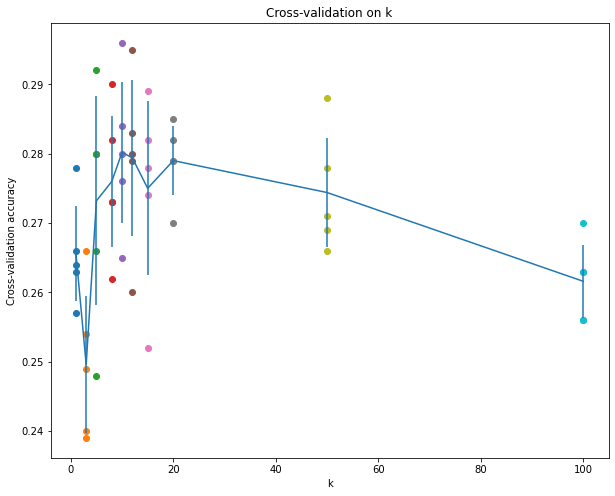

In [27]:
# 显示得到的原始观察数据
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 显示趋势线，以及与标准差相对应的误差条
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr = accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [28]:
# 根据交叉验证，超参数 k = 10
# 使用所有的训练数据重新训练模型，然后对测试数据进行标注
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred =  classifier.predict(X_test, k = best_k)

# 计算准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
